<a href="https://colab.research.google.com/github/orbenishay/Regression-Project/blob/Hagai/Amsterdam1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Amsterdam Airbnb** 
https://www.kaggle.com/adityadeshpande23/amsterdam-airbnb

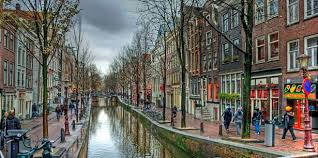


**Introduce noise to the dataset**:
*   Outliers (per subset)
*   Bivariate outlier
*   Zeros
*   Nulls

**Pipeline**:
*   Feature selection
*   Relevance
*   Drop columns with high correlation
*   Scaling
*   Order categorical data
*   Target transformation (log?)
*   Split train/test
*   List item
*   List item


*   List item







EDA:

Data Cleansing:

Models:






In [29]:

import pandas as pd # General tools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import warnings
from datetime import datetime # Pandas
from datetime import timedelta
from scipy.optimize import curve_fit# For curve fitting
from sklearn.base import TransformerMixin # For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator # For predictions
from sklearn.metrics import mean_squared_log_error as msle # For scoring
from sklearn.metrics import mean_squared_error as mse # For scoring
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
import pydot as pyd # For the tree visualization
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.model_selection import train_test_split # For validation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
!pip install pydot;


In [30]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Saving Amsterdam2.csv to Amsterdam2.csv


In [52]:
bnb_orig = pd.read_csv('Amsterdam2.csv', index_col='#')
bnb=bnb_orig

bnb['ring']=pd.cut(x=bnb['d_centre'], bins=4, right=True, labels=['Center','Off Center','periphery','Suburbs'],\
retbins=False, precision=3, include_lowest=False, duplicates='raise') # bin distance  

bnb.head()

,latitude,longitude,d_centre,accommodates,bathrooms,bedrooms,calculated_host_listings_count,guests_included,host_listings_count,minimum_nights,number_of_reviews,instant_bookable,room_type,review_avg,price,ring
#,,,,,,,,,,,,,,,,
5256,52.354417,4.810184,6.652019,1.0,1.0,0.0,1,1,1,50,0,Possible,Private room,0.720755,30,Off Center
2313,52.391214,4.912759,1.613341,1.0,1.0,0.0,1,1,1,3,1,Possible,Private room,0.790446,35,Center
4687,52.353466,4.831334,5.433321,1.0,1.0,0.0,1,1,1,7,0,Not Possible,Entire home/apt,0.739732,35,Off Center
8420,52.319091,4.953274,7.613078,3.0,1.0,0.0,1,1,2,1,2,Not Possible,Entire home/apt,0.729420,40,Off Center
1431,52.369448,4.877232,1.854677,1.0,1.0,0.0,1,1,1,1,13,Not Possible,Private room,0.711719,41,Center


## **Data Cleansing**

In [51]:
# DataFrame actions:
bnb = bnb[bnb.isnull().sum(axis=1)<3] # Remove rows with more than 3 `NaN`'s.
bnb = bnb.loc[:, ~bnb.columns.str.contains(r'review', case=False)] # remove specific columns
bnb.drop_duplicates(inplace=True) # Remove duplicates
bnb.drop_duplicates(subset=['director_name', 'title_year'], inplace=True) # Remove duplicates with subsets: Only consider certain columns for identifying duplicates, by default use all of the columns
bnb.index.value_counts().head() # look for duplications

# Clean the data:
bnb = bnb.loc[bnb['bedrooms']<8,:] # filter dataset based on a column's values
bnb = bnb.loc[(bnb.bedrooms<8) & (bnb.bathrooms<8)]
bnb = bnb.loc[bnb.accommodates * bnb.minimum_nights != 0] # remove rows with 0 values at either columns
bnb = bnb.loc[(bnb.bedrooms - bnb.bathrooms).abs() < 5] # remove based on TPA

# def drop_zeros(df): # remove zeros
#     return df.loc[df.x * df.y * df.z != 0]
# zeros_dropper = FunctionTransformer(drop_zeros, validate=False)
# diamonds = zeros_dropper.fit_transform(diamonds)

bnb.shape # after each cleaning step: check how many rows were deleted 

for col in bnb.columns: # remove outliers >3 sigma from all the fields
    if bnb[col].dtype == 'float64':
        std = bnb[col].std()
        ave = bnb[col].mean()
        bnb = bnb.loc[bnb[col].between(ave-3*std, ave+3*std)]
        print(f'processing {col:10} --> {bnb.shape[0]:5} assets remain')

# xz_model = LinearRegression().fit(diamonds[['x']], diamonds.z) # remove bivariate outliers
# z_pred = xz_model.predict(diamonds[['x']])
# diamonds = diamonds.loc[(diamonds.z-z_pred).abs()<0.35]

# x_carat_model = LinearRegression().fit(diamonds[['x']], diamonds.carat) # remove by linear regression
# carat_pred = x_carat_model.predict(diamonds[['x']])
# diamonds = diamonds.loc[(diamonds.carat-carat_pred).abs()<0.3]
# sns.scatterplot(x='x', y='carat', data=diamonds)

# def exponential(x, a, b, c, d): # remove by exponential regression
#     return a + b*np.exp(c*x+d)
# popt, _ = curve_fit(exponential, xdata=diamonds.x, ydata=diamonds.carat)
# print(popt)
# a, b, c, d = popt
# carat_pred = diamonds.x.apply(exponential, a=a, b=b, c=c, d=d) # plot the curve
# plt.plot(diamonds.x, diamonds.carat, '.b', 
#               diamonds.x, carat_pred, '.g')
# plt.text(6, 0.5, r'$carat = -0.47+19.56 x exp(0.3x-4.56)$')
# residuals = (diamonds.carat - carat_pred).abs() #evaluate the residuals and remove data points as we wish.
# residuals.hist(bins=100)


processing latitude   --> 14597 assets remain
processing longitude  --> 14355 assets remain
processing d_centre   --> 14155 assets remain
processing accommodates --> 14045 assets remain
processing bathrooms  --> 13348 assets remain
processing bedrooms   --> 13210 assets remain


## **Dataset explration**

In [63]:
bnb.loc[:,['d_centre','price']] # slice dataframe (show specific columns)
bnb.bedrooms.loc[:,].count() # count of entries in a column of a df
bnb.shape # dimention of df
bnb[['room_type','price']].groupby('room_type').describe() # describe with subset
bnb.bedrooms.value_counts().head(10) #Count entries per value:
bnb.nunique() # how many values per field

latitude                          14977
longitude                         14999
d_centre                          14999
accommodates                         14
bathrooms                            12
bedrooms                             11
calculated_host_listings_count       27
guests_included                      14
host_listings_count                  32
minimum_nights                       37
number_of_reviews                   274
instant_bookable                      2
room_type                             3
review_avg                        14999
price                               323
ring                                  4
dtype: int64

## **Transformation**

In [0]:
# non-numerical data into numerical data - utilize the "order" of the categories
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
cut_map = dict(zip(cut_order, range(len(cut_order))))
diamonds.loc[:, 'cut'] = diamonds['cut'].map(cut_map)


X = diamonds.drop('price', axis=1, inplace=False)
y = diamonds.price
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=142857) # this splits the dataset randomly but the same way

# Create a function based on our intuition about the influence of the features
def diamond_pricing(X, a, b, c, d):
    return (a + X.carat) ** (b*X.cut + c*X.color + d*X.clarity) 

p_opt, _ = curve_fit(diamond_pricing, X_train, y_train) # apply curve fit

prms = dict(zip(['a', 'b', 'c', 'd'], p_opt))
print(prms)

y_pred = X_train.apply(diamond_pricing, axis=1, **prms)

# Convert categorical fields to numeric:
people_dummies = pd.get_dummies(people, drop_first=True)

# another pre-processing to convert binary field to numeric
tips['sex'] = tips['sex'].replace({'Female': 0, 'Male': 1})

## **EDA**

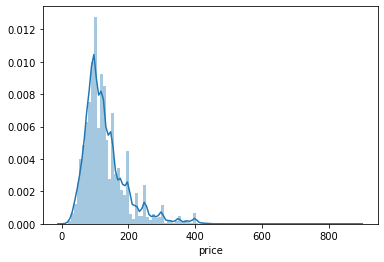

In [72]:
# bnb.hist(column='price', by='instant_bookable', bins=50, sharex=True, sharey=True);
sns.distplot(bnb.price, bins=100, kde=True);
# bnb[['price']].sort_values('price', ascending=False).head(20)

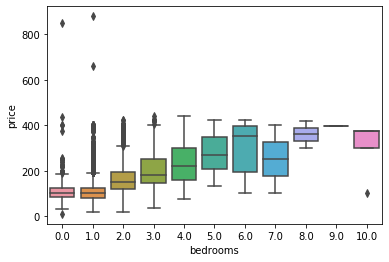

In [78]:
sns.boxplot(x='bedrooms', y='price', hue=None, data=bnb, order=None, hue_order=None);

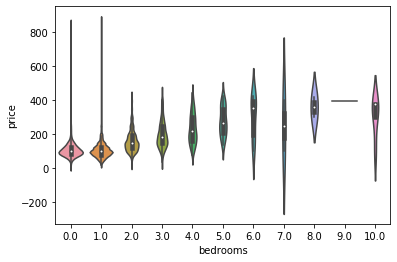

In [64]:
sns.violinplot(x='bedrooms', y='price', data=bnb); #order=cut_order

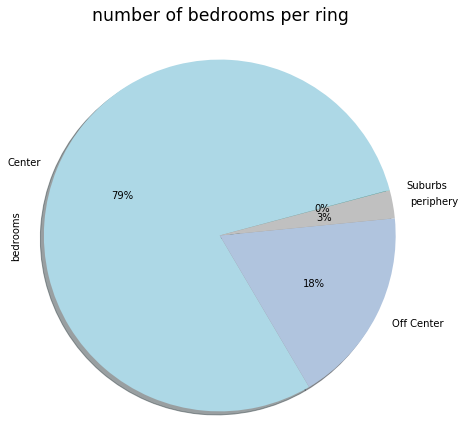

In [32]:
my_colors = ['lightblue','lightsteelblue','silver','lightseagreen','khaki','peachpuff']
Pie = bnb.groupby('ring')['bedrooms'].sum().plot.pie(autopct='%1.f%%', startangle=15,colors=my_colors,shadow = True,figsize=(7, 7))
plt.title('number of bedrooms per ring', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.axis('equal')
plt.show()

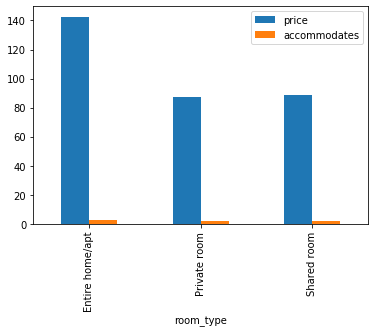

In [33]:
bnb.groupby('room_type').agg({'price': 'mean', 'accommodates': 'median'}).plot(kind='bar');


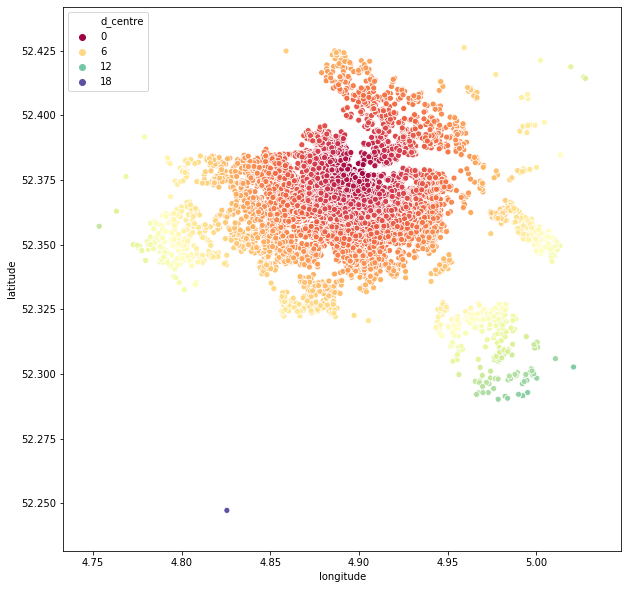

In [40]:
# ax = bnb.plot(kind = 'scatter',x='longitude',y='latitude', c='d_centre',colormap='viridis', figsize = (10, 10))
plt.figure(figsize=(10,10))
# sns.scatterplot(x='longitude', y='latitude', hue='ring', data=bnb, palette="Spectral")
sns.scatterplot(x='longitude', y='latitude', hue='d_centre', data=bnb, palette="Spectral");

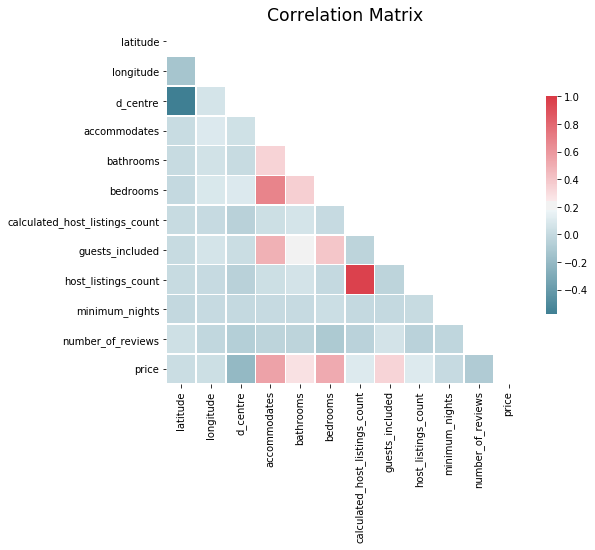

In [0]:
# Correlation matrix:
corr = bnb.corr()
mask = np.zeros_like(corr, dtype=np.bool) #Generating a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8,8)) #Setting up the matplotlib figure
cmap = sns.diverging_palette(220,10, as_cmap=True) #Generating a custom diverging colormap
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax) #Drawing the heatmap with the mask
plt.title("Correlation Matrix", fontsize='xx-large')
plt.show()

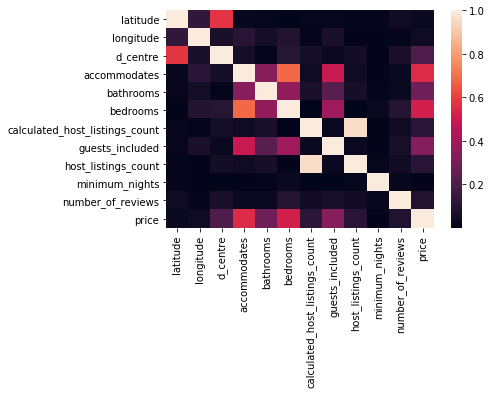

In [0]:
sns.heatmap(bnb.corr().abs())

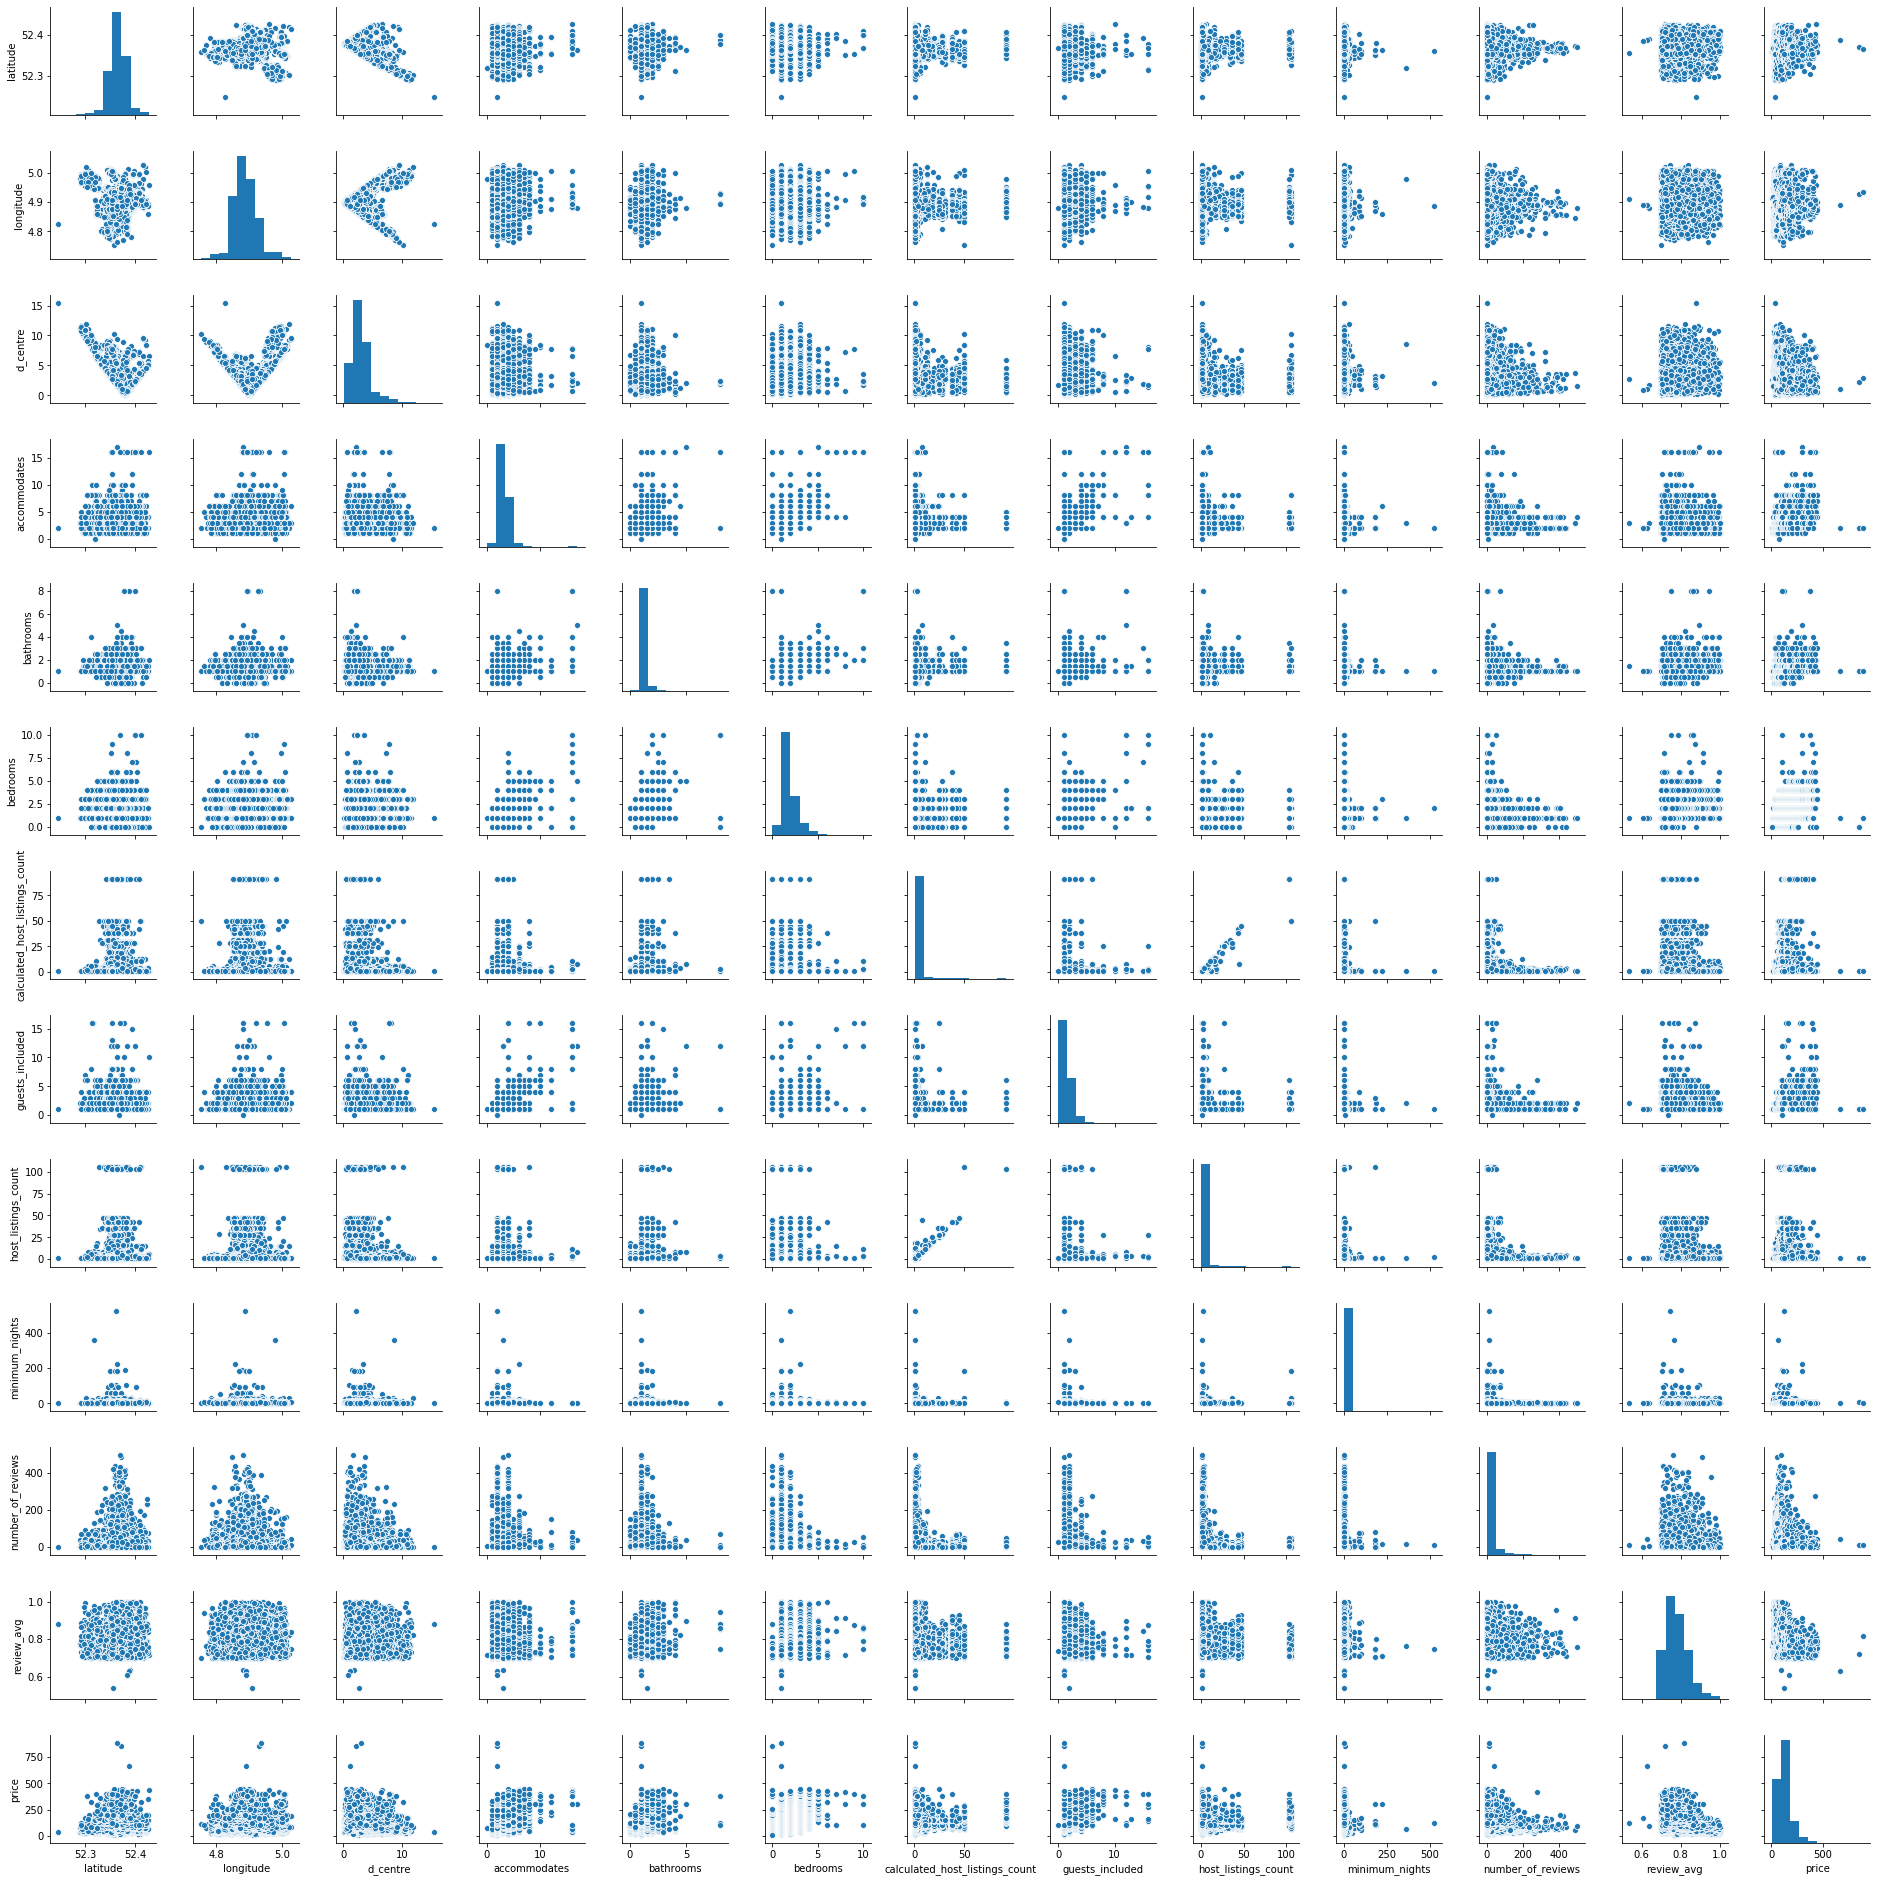

In [42]:
bnb_num = bnb.select_dtypes(include=np.number)
sns.pairplot(bnb_num, height=2)

## **Outlier Removal**